# Extremes - Demo

In [1]:
import autoroot
import ee
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray

In [2]:

from geo_toolz._src.masks.country import add_country_mask
from geo_toolz._src.masks.land import add_land_mask
from geo_toolz._src.masks.ocean import add_ocean_mask
from geo_toolz._src.validation.coords import validate_longitude, validate_latitude
from geo_toolz._src.encoders.time import time_rescale, time_unrescale
from geo_toolz._src.discretize.grid import RegularLonLat
from geo_toolz._src.data.reanalysis.gee import download_era5_gee
from geo_toolz.extremes import calculate_block_maxima_ts, calculate_pot_quantile, calculate_pot_ts, calculate_pp_counts_ts, calculate_pp_stats_ts
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

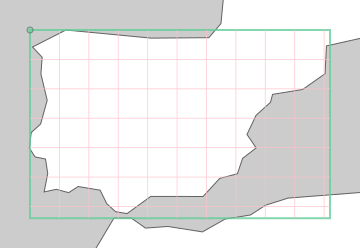

In [3]:
gbox = RegularLonLat.init_from_country("E", 1/4)
gbox.gbox

In [4]:
ds = download_era5_gee("era5_daily", gbox)
ds

<xarray.Dataset> Size: 891MB
Dimensions:                     (time: 15165, lon: 51, lat: 32)
Coordinates:
  * time                        (time) datetime64[ns] 121kB 1979-01-02 ... 20...
  * lon                         (lon) float32 204B -9.375 -9.125 ... 2.875 3.125
  * lat                         (lat) float32 128B 43.62 43.38 ... 36.12 35.88
Data variables:
    mean_2m_air_temperature     (time, lon, lat) float32 99MB ...
    minimum_2m_air_temperature  (time, lon, lat) float32 99MB ...
    maximum_2m_air_temperature  (time, lon, lat) float32 99MB ...
    dewpoint_2m_temperature     (time, lon, lat) float32 99MB ...
    total_precipitation         (time, lon, lat) float32 99MB ...
    surface_pressure            (time, lon, lat) float32 99MB ...
    mean_sea_level_pressure     (time, lon, lat) float32 99MB ...
    u_component_of_wind_10m     (time, lon, lat) float32 99MB ...
    v_component_of_wind_10m     (time, lon, lat) float32 99MB ...
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [5]:
def preprocess(ds):
    # select variable
    ds = ds[["maximum_2m_air_temperature"]]
    ds = ds.rename({"maximum_2m_air_temperature": "t2m_max"})
    
    # validate units
    ds = ds.pint.quantify({"t2m_max": "kelvin"})
    ds["t2m_max"] = ds["t2m_max"].pint.to("degC")
    ds = ds.pint.dequantify()
    
    # validate coordinates
    ds = validate_latitude(ds)
    ds = validate_longitude(ds)

    return ds


In [6]:
%timeit

ds = preprocess(ds)
ds

<xarray.Dataset> Size: 99MB
Dimensions:  (time: 15165, lon: 51, lat: 32)
Coordinates:
  * time     (time) datetime64[ns] 121kB 1979-01-02 1979-01-03 ... 2020-07-09
  * lon      (lon) float32 204B -9.375 -9.125 -8.875 ... 2.625 2.875 3.125
  * lat      (lat) float32 128B 43.62 43.38 43.12 42.88 ... 36.38 36.12 35.88
Data variables:
    t2m_max  (time, lon, lat) float32 99MB 13.11 13.28 13.21 ... 38.16 37.06
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

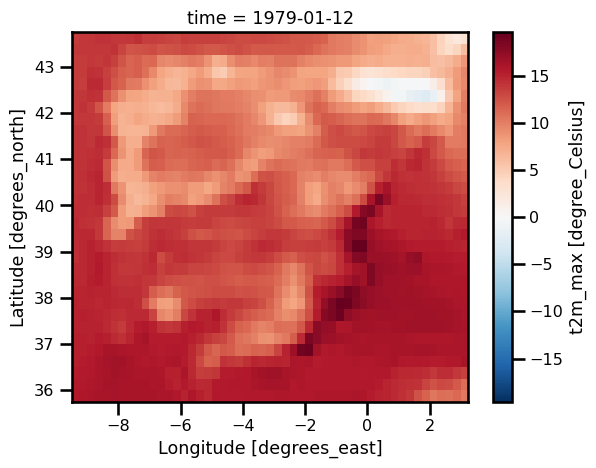

In [7]:
ds.t2m_max.isel(time=10).sortby("lat").sortby("lon").plot.pcolormesh(x="lon", y="lat")

## Country Mask

In [8]:
ds = add_country_mask(ds, country="Spain")

In [9]:
ds

<xarray.Dataset> Size: 99MB
Dimensions:     (time: 15165, lon: 51, lat: 32)
Coordinates:
  * time        (time) datetime64[ns] 121kB 1979-01-02 1979-01-03 ... 2020-07-09
  * lon         (lon) float32 204B -9.375 -9.125 -8.875 ... 2.625 2.875 3.125
  * lat         (lat) float32 128B 43.62 43.38 43.12 42.88 ... 36.38 36.12 35.88
    spain_mask  (lat, lon) int16 3kB 0 0 0 0 0 1 1 1 1 0 ... 0 0 0 0 0 0 0 0 0 0
Data variables:
    t2m_max     (time, lon, lat) float32 99MB 13.11 13.28 13.21 ... 38.16 37.06
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

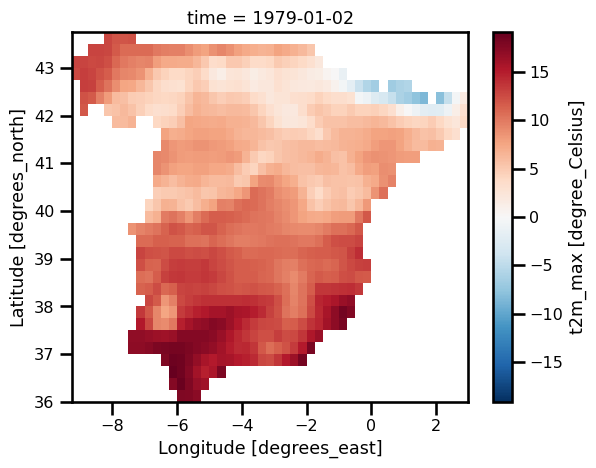

In [10]:
ds.isel(time=0).where(ds.spain_mask==1, drop=True).t2m_max.plot.pcolormesh(x="lon", y="lat")

## Block

In [11]:
ds_madrid = ds.sel(lon=-3.703790, lat=40.416775, method="nearest")
ds_madrid

<xarray.Dataset> Size: 182kB
Dimensions:     (time: 15165)
Coordinates:
  * time        (time) datetime64[ns] 121kB 1979-01-02 1979-01-03 ... 2020-07-09
    lon         float32 4B -3.625
    lat         float32 4B 40.38
    spain_mask  int16 2B 1
Data variables:
    t2m_max     (time) float32 61kB 10.84 10.95 8.061 ... 38.24 34.31 32.77
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [12]:
extremes_madrid = calculate_block_maxima_ts(ds_madrid, 12)
extremes_madrid

<xarray.Dataset> Size: 15kB
Dimensions:     (time: 1263)
Coordinates:
  * time        (time) datetime64[ns] 10kB 1979-01-16T12:00:00 ... 2020-07-03...
    lon         float32 4B -3.625
    lat         float32 4B 40.38
    spain_mask  int16 2B 1
Data variables:
    t2m_max     (time) float32 5kB 14.24 13.82 15.12 13.35 ... 28.89 36.73 38.24
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

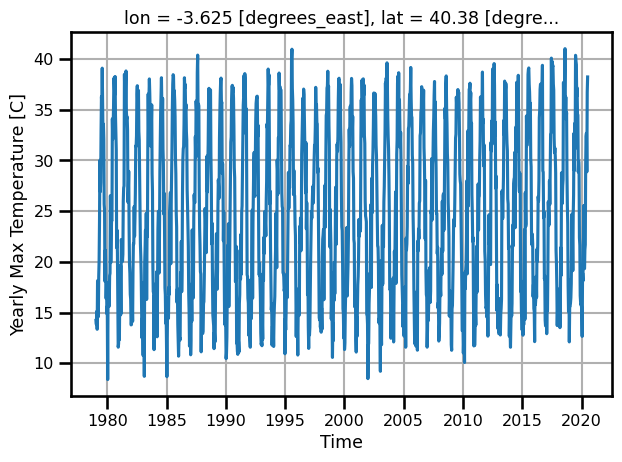

In [13]:
fig, ax = plt.subplots()

extremes_madrid.t2m_max.plot(ax=ax)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()

## Peak Over Threshold

In [14]:
# # calculate threshold for pot
# threshold = calculate_pot_quantile(ds_madrid.t2m_max, quantile=0.98)
# # select remaining (dont drop)
# extremes_pot = ds_madrid.t2m_max.where(ds_madrid.t2m_max >= threshold, drop=True)

extremes_pot = calculate_pot_ts(ds_madrid.t2m_max, quantile=0.98, decluster_freq=None)
print(f"# Extremes: {extremes_pot.shape}")

# Extremes: (304,)


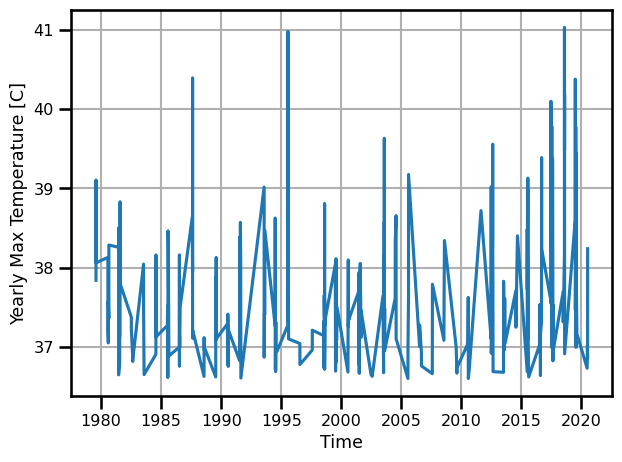

In [15]:
fig, ax = plt.subplots()

extremes_pot.plot(ax=ax)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]",
    # ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()

In [16]:

# decluster
extremes_pot_dc = calculate_pot_ts(ds_madrid.t2m_max, quantile=0.98, decluster_freq=5)
print(f"# Extremes: {extremes_pot_dc.shape}")

# Extremes: (161,)


Wherever the times for the original pot are not in those of the declustered, we want to keep those.

In [17]:
diff_times = np.setdiff1d(extremes_pot.time.values, extremes_pot_dc.time.values)
diff = extremes_pot.sel(time=diff_times)
print(f"# Diff: {diff.shape}")

# Diff: (247,)


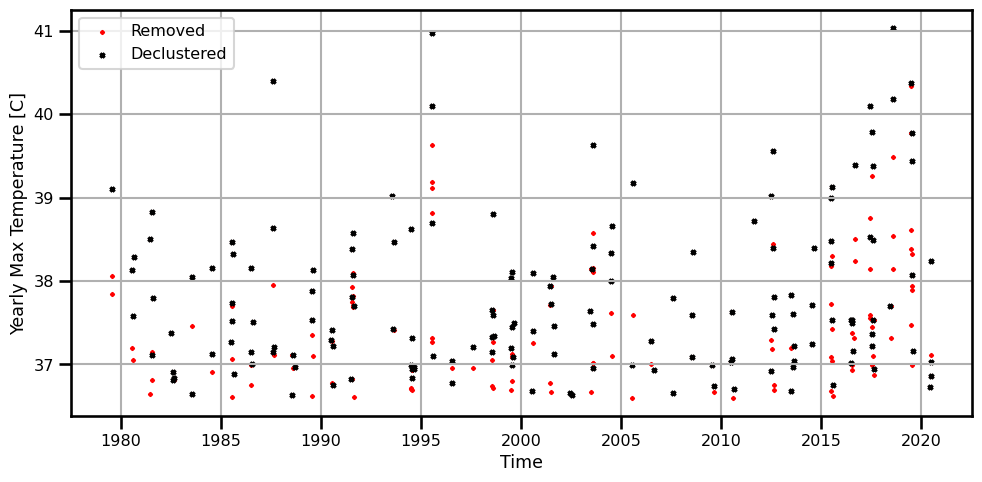

In [18]:
fig, ax = plt.subplots(figsize=(10,5))


diff.plot.scatter(ax=ax, s=5, c="red", marker="x", label="Removed")
extremes_pot_dc.plot.scatter(ax=ax, s=10, c="black", marker="x", label="Declustered")

ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]",
    # ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()

## Counting Exceedences

In [19]:
extremes_pp = calculate_pp_counts_ts(ds_madrid.t2m_max, quantile=0.98, time_freq=5)
extremes_bm = calculate_pp_stats_ts(ds_madrid.t2m_max, fn=np.median, quantile=0.98, time_freq=5)

/Users/eman/miniconda3/envs/bayesevt/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eman/miniconda3/envs/bayesevt/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
extremes_pp, extremes_bm

(<xarray.DataArray 't2m_max' (time: 3033)> Size: 24kB
 array([0, 0, 0, ..., 4, 0, 3])
 Coordinates:
     lon         float32 4B -3.625
     lat         float32 4B 40.38
     spain_mask  int16 2B 1
   * time        (time) datetime64[ns] 24kB 1979-01-04 1979-01-09 ... 2020-07-07,
 <xarray.DataArray 't2m_max' (time: 3033)> Size: 24kB
 array([nan, nan, nan, ...,  4.,  0.,  1.])
 Coordinates:
     lon         float32 4B -3.625
     lat         float32 4B 40.38
     spain_mask  int16 2B 1
   * time        (time) datetime64[ns] 24kB 1979-01-04 1979-01-09 ... 2020-07-07)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


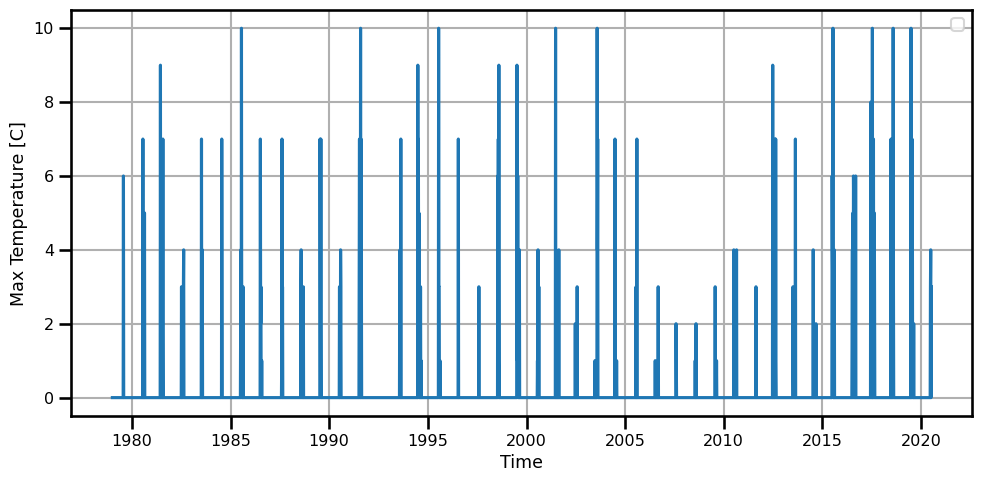

In [21]:
fig, ax = plt.subplots(figsize=(10,5))


# extremes_ec_.plot(x="time", y="t2m_max", ax=ax, s=0.1, c="black", marker="-", label="Counts")
extremes_pp.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Max Temperature [C]",
    # ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


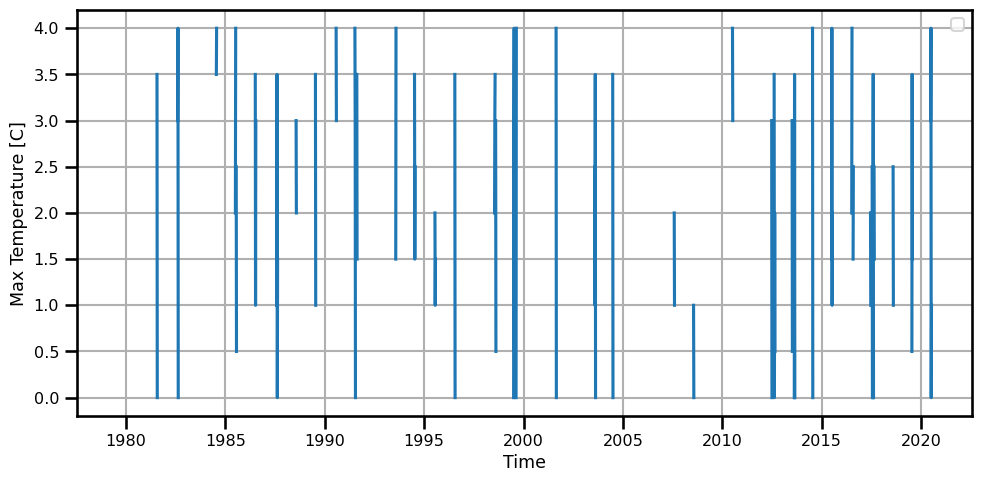

In [22]:
fig, ax = plt.subplots(figsize=(10,5))


# extremes_ec_.plot(x="time", y="t2m_max", ax=ax, s=0.1, c="black", marker="-", label="Counts")
extremes_bm.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Max Temperature [C]",
    # ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
ds_summer = ds_madrid.t2m_max.sel(time=ds_madrid.time.dt.month.isin([6,7,8]))

extremes_pp = calculate_pp_counts_ts(ds_summer, quantile=0.98, time_freq=5)
extremes_bm = calculate_pp_stats_ts(ds_summer, fn=np.nanmedian, quantile=0.98, time_freq=5)

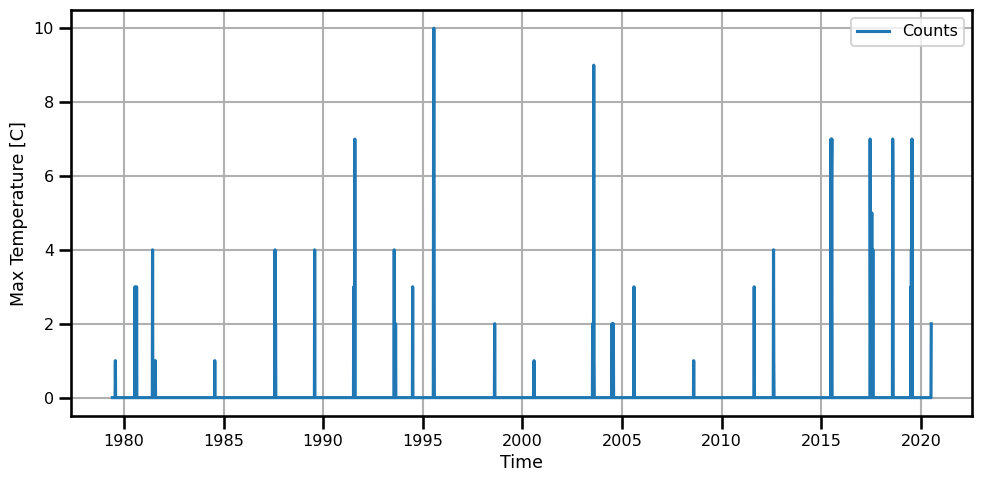

In [24]:
fig, ax = plt.subplots(figsize=(10,5))


# extremes_ec_.plot(x="time", y="t2m_max", ax=ax, s=0.1, c="black", marker="-", label="Counts")
extremes_pp.plot(ax=ax, label="Counts")

ax.set(
    xlabel="Time",
    ylabel="Max Temperature [C]",
    # ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


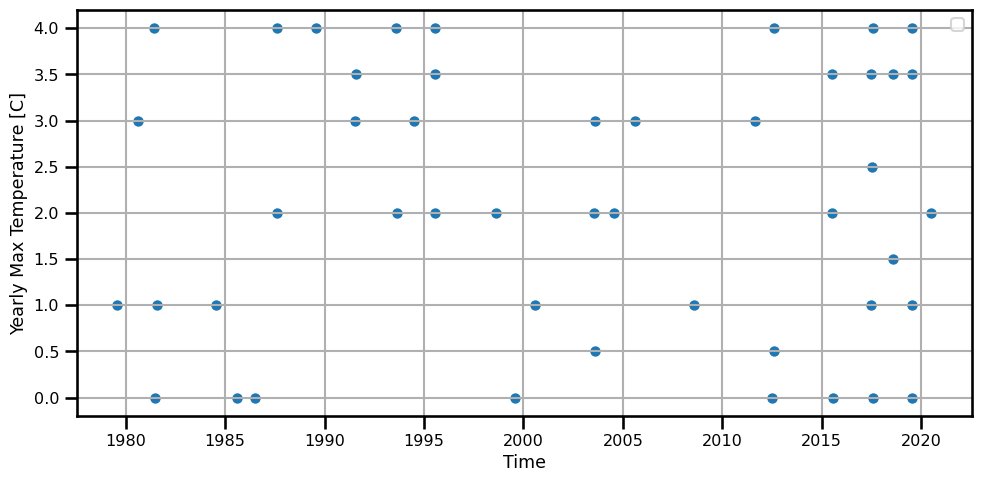

In [25]:
fig, ax = plt.subplots(figsize=(10,5))


# extremes_ec_.plot(x="time", y="t2m_max", ax=ax, s=0.1, c="black", marker="-", label="Counts")
extremes_bm.plot.scatter(ax=ax, x="time", y="t2m_max")

ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]",
    # ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()